In [1]:
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Lambda
from tensorflow.keras import backend as K
import tensorflow_addons
import tensorflow_datasets as tfds
import math

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

WEIGHTS_TRAINED_DIR = 'model_weights/trained'
RESULT_PLOTS_DIR = 'plots'

import numpy as np
import random
from tqdm.notebook import tqdm

def square_activation(x):
    return K.square(x)

In [2]:
cd ..

/home/han/Desktop/part-ii-project/part-ii-project


In [3]:
from model.model_funcs import save_data

In [4]:
cd notebooks

/home/han/Desktop/part-ii-project/part-ii-project/notebooks


Load in a pretrained VGG model.

In [5]:
from keras_vggface.vggface import VGGFace
vggface = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

vggface.summary()


Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

Prepare generators used for training the triplet loss network and the discriminator.

In [6]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, batch_size, images, labels):
        self.batch_size = batch_size
        self.images = images
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(self.size() / self.batch_size)

    def __getitem__(self, index):
        slice_range = [index * self.batch_size, min((index + 1) * self.batch_size, self.size())]

        embeddings = self.images[slice(*slice_range)]
        labels = self.labels[slice(*slice_range)]
        
        ims = []
        for e in embeddings:
            ims.append(e)

        return np.array(ims), labels
    
    def on_epoch_end(self):
        batches_ok = False

        while not batches_ok:
            indices = np.arange(self.images.shape[0])
            np.random.shuffle(indices)
            self.images = self.images[indices]
            self.labels = self.labels[indices]
            
            batches_ok = True
            
            for index in range(self.__len__()):
                ims, labs = self.__getitem__(index)
                if len(np.unique(labs)) == len(labs):
                    batches_ok = False
                    break

    def size(self):
        return len(self.labels)
    
    
class DataGeneratorSiamese(tensorflow.keras.utils.Sequence):
    def __init__(self, batch_size, images, labs, ids):
        self.batch_size = batch_size        
        total = len(labs)
        self.ids = ids
        
        self.pairs = []
        self.pair_ids = []
        self.labels = []
        
        memory = set()
        
        for l in [0, 1]:
            for _ in tqdm(range(10000)):
                while True:
                    index_a = random.randint(0, total - 1)
                    index_b = random.randint(0, total - 1)

                    if (labs[index_a] != labs[index_b]) != l:
                        continue
                    if index_a == index_b or (index_a, index_b) in memory:
                        continue
                    
                    memory.add((index_a, index_b))
                    self.pairs.append([index_a, index_b])
                    self.pair_ids.append([ids[index_a], ids[index_b]])
                    self.labels.append(l)
                    break
                    
        self.pairs = np.array(self.pairs)
        self.labels = np.array(self.labels)
        self.images = images
        

    def __len__(self):
        return math.ceil(self.size() / self.batch_size)

    def __getitem__(self, index):
        slice_range = [index * self.batch_size, min((index + 1) * self.batch_size, self.size())]

        pairs = self.pairs[slice(*slice_range)]
        labels = self.labels[slice(*slice_range)]
        
        image_pairs = []
        
        for p in pairs:
            im_1 = self.images[p[0]]
            im_2 = self.images[p[1]]
                        
            image_pair = np.concatenate((im_1, im_2))
            image_pairs.append(image_pair)

        return np.array(image_pairs), labels
    
    def get_all(self):
        image_pairs = []
        labels = self.labels[:]
        
        for p in self.pairs:
            im_1 = self.images[p[0]]
            im_2 = self.images[p[1]]
                        
            image_pair = np.concatenate((im_1, im_2))
            image_pairs.append(image_pair)

        return np.array(image_pairs), labels, np.array(self.pair_ids)
    
    def on_epoch_end(self):
        batches_ok = False

        indices = np.arange(self.pairs.shape[0])
        np.random.shuffle(indices)
        self.pairs = self.pairs[indices]
        self.labels = self.labels[indices]
        
    def size(self):
        return len(self.labels)


Load in a subset of the celebA dataset, containing the first 1000 identities.

In [7]:
import io
from PIL import Image

id_file = open('celebA/ids.txt', 'r')
s = id_file.read()
s = s.split('\n')

d = {}
c = 0

for l in s:
    if len(l.split(' ')) != 2:
        break
    face_id = int(l.split(' ')[1])
    
    if face_id not in d:
        d[face_id] = []
        
    name = l.split(' ')[0]
    name = name.split('.')[0] + '.png'
    
    d[face_id].append('celebA/img_align_celeba_png/' + name)
    
    
ids = [i for i in range(1, 1000)]

Use the pretrained network to extract CNN features from the images.

In [8]:
def load_faces():
    labels = []
    encodings_all = []
    data = []
    
    for face_id in ids:
        for path in d[face_id]:
            labels.append(face_id)

            img = Image.open(path)
            img_r = img.resize((224, 224), Image.ANTIALIAS)
            data.append(np.array(img_r.getdata()).reshape((224, 224, 3)))
            img.close()   
            
            if len(data) == 64:
                data = np.array(data)
                encodings = vggface(data)
                data = []
                encodings_all.extend(list(encodings.numpy()))
                            
    return np.array(encodings_all), np.array(labels)

def load_face(idx):
    i = 0
    for face_id in ids:
        for path in d[face_id]:
            if i == idx:
                img = Image.open(path)
                img_r = img.resize((224, 224), Image.ANTIALIAS)
                img.close()
                return img_r
            i += 1

In [ ]:
celeb_embeddings, celeb_labels = load_faces()

In [9]:
celeb_embeddings = np.load('embeddings/celeb_20k.npy')
celeb_labels = np.load('embeddings/celeb_20k_labs.npy')

Let's look at a few examples...

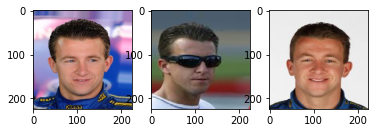

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
ax[0].imshow(load_face(0))
ax[1].imshow(load_face(1))
ax[2].imshow(load_face(2))

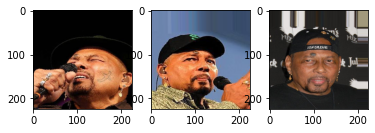

In [11]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(load_face(345))
ax[1].imshow(load_face(346))
ax[2].imshow(load_face(347))

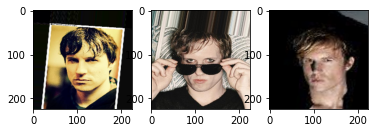

In [12]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(load_face(4124))
ax[1].imshow(load_face(4125))
ax[2].imshow(load_face(4126))

In [13]:
embeddings_train = []
labels_train = []

embeddings_test = []
labels_test = []

train_indexes = []
test_indexes = []

train_ids = np.arange(0, 500)
test_ids = np.arange(500, 1000)

for i, face in enumerate(celeb_embeddings):
    if celeb_labels[i] in train_ids:
        embeddings_train.append(face)
        labels_train.append(celeb_labels[i])
        train_indexes.append(i)
    if celeb_labels[i] in test_ids:
        embeddings_test.append(face)
        labels_test.append(celeb_labels[i])
        test_indexes.append(i)
    
embeddings_train = np.array(embeddings_train)
embeddings_test = np.array(embeddings_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

print(embeddings_train.shape)
print(embeddings_test.shape)

(10910, 512)
(10210, 512)


Now initialise the generators we are going to use for training and testing.

In [14]:
dg_train = DataGenerator(256, embeddings_train, labels_train)
dg_test = DataGenerator(256, embeddings_test, labels_test)

In [15]:
dg_train_siamese = DataGeneratorSiamese(32, embeddings_train, labels_train, train_indexes)
dg_test_siamese = DataGeneratorSiamese(32, embeddings_test, labels_test, test_indexes)

In [16]:
len(dg_test_siamese.get_all()[1])

20000

Train the triplet loss network (which will produce the dense embeddings).

In [17]:
model_encoder = Sequential()
model_encoder.add(Dense(64, input_shape=(512,)))
model_encoder.add(Activation(square_activation))
model_encoder.add(Lambda(lambda tensor: tensorflow.math.l2_normalize(tensor, axis=1)))

model_encoder.compile(
    optimizer=tensorflow.keras.optimizers.Adam(lr=0.003),
    loss=tensorflow_addons.losses.TripletSemiHardLoss(margin=0.5),
)

In [18]:
model_encoder.fit_generator(
            generator=dg_train,
            validation_data=dg_test,
            epochs=50
)

/home/han/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
43/43 [==============================] - 2s 18ms/step - loss: 0.4764 - val_loss: 0.4638
Epoch 2/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4577 - val_loss: 0.4584
Epoch 3/50
43/43 [==============================] - 0s 11ms/step - loss: 0.4445 - val_loss: 0.4517
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4292 - val_loss: 0.4483
Epoch 5/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4275 - val_loss: 0.4472
Epoch 6/50
43/43 [==============================] - 1s 12ms/step - loss: 0.4159 - val_loss: 0.4472
Epoch 7/50
43/43 [==============================] - 0s 11ms/step - loss: 0.4116 - val_loss: 0.4466
Epoch 8/50
43/43 [==============================] - 0s 12ms/step - loss: 0.4072 - val_loss: 0.4454
Epoch 9/50
43/43 [==============================] - 0s 11ms/step - loss: 0.4007 - val_loss: 0.4424
Epoch 10/50
43/43 [==============================] - 1s 12ms/step - loss: 0.3936 - val_loss: 0.4449
Epoch 11/

Now, use the trained triplet loss network to train a discriminator that gives the binary output.

In [19]:
for layer in model_encoder.layers[:]:
    layer.trainable = False

In [20]:
input_layer = Input(shape=(512 * 2,))

slice_layer_1 = Lambda(lambda x: x[:, 0:512])
slice_layer_2 = Lambda(lambda x: x[:, 512:2 * 512])

left_input = slice_layer_1(input_layer)
right_input = slice_layer_2(input_layer)

square = Lambda(lambda x: K.square(x)) 

encoded_l = model_encoder(left_input)
encoded_r = model_encoder(right_input)

l1_layer = Lambda(lambda tensors: K.square(tensors[0] - tensors[1]))
l1_distance = l1_layer([encoded_l, encoded_r])

fc_model = Dense(64)(l1_distance)
fc_model = Activation(square_activation)(fc_model)
fc_model = Dense(1)(fc_model)
fc_model = Activation('sigmoid')(fc_model)

In [21]:
fc_model = Model(inputs=[input_layer], outputs=fc_model)

# pos_recall and neg_recall functions are ***borrowed*** from: https://gist.github.com/arnaldog12/5f2728f229a8bd3b4673b72786913252#file-custom_metrics-py
# since for some reason I cannot find a default Tensorflow implementation.
def pos_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def neg_recall(y_true, y_pred):
    y_true = y_true * -1 + 1
    y_pred = y_pred * -1 + 1

    true_negatives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_negatives / (possible_negatives + K.epsilon())
    return recall

fc_model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(lr=0.003),
    loss='binary_crossentropy',
    metrics=['accuracy', pos_recall, neg_recall],
)

In [22]:
fc_model.fit_generator(
            generator=dg_train_siamese,
            validation_data=dg_test_siamese,
            epochs=3
)

Epoch 1/3
625/625 [==============================] - 2s 3ms/step - loss: 0.4959 - accuracy: 0.7110 - pos_recall: 0.4276 - neg_recall: 0.2849 - val_loss: 0.3656 - val_accuracy: 0.8482 - val_pos_recall: 0.4618 - val_neg_recall: 0.3877
Epoch 2/3
625/625 [==============================] - 2s 2ms/step - loss: 0.1559 - accuracy: 0.9417 - pos_recall: 0.9438 - neg_recall: 0.9394 - val_loss: 0.3529 - val_accuracy: 0.8532 - val_pos_recall: 0.8900 - val_neg_recall: 0.8148
Epoch 3/3
625/625 [==============================] - 2s 2ms/step - loss: 0.1556 - accuracy: 0.9374 - pos_recall: 0.9348 - neg_recall: 0.9395 - val_loss: 0.3432 - val_accuracy: 0.8517 - val_pos_recall: 0.8384 - val_neg_recall: 0.8644


In [23]:
fc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           32832       lambda_1[0][0]                   
                                                                 lambda_2[0][0]               

Let's see how well the discriminator performs on the test set.

In [24]:
fc_model.evaluate(dg_test_siamese)

625/625 [==============================] - 1s 1ms/step - loss: 0.3432 - accuracy: 0.8517 - pos_recall: 0.8376 - neg_recall: 0.8652


[0.34318941831588745,
 0.8517000079154968,
 0.8375841975212097,
 0.8652458786964417]

In [25]:
fc_model.save('saved_model/cryptoface')

INFO:tensorflow:Assets written to: saved_model/cryptoface/assets


Extract and save the top portion of the model, and prepare the inputs for evaluation.

In [26]:
top_end = Sequential([Input(shape=(64,))] + fc_model.layers[5:])
top_end.summary()
save_data(top_end, 'CRYPTOFACE', testX=None, linear=[])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


Save the embeddings for later use.

In [27]:
test_set, test_labels, _ = dg_test_siamese.get_all()
embeddings_left = model_encoder(slice_layer_1(test_set)).numpy()
embeddings_right = model_encoder(slice_layer_2(test_set)).numpy()
test_pairs = np.concatenate((embeddings_left, embeddings_right), axis=1)
np.save('data/CRYPTOFACE_testpairs.npy', test_pairs)
np.save('data/CRYPTOFACE_preds.npy', fc_model(test_set).numpy().squeeze())

### Evaluation of performance

In [ ]:
from tqdm.notebook import tqdm

x = 0.5 + np.arange(-100, 101) / 200    

In [ ]:
def true_positive(preds, labels):
    mask = np.argwhere(labels == 1)
    return np.sum(preds[mask]) / len(labels[mask])
    
def false_positive(preds, labels):
    mask = np.argwhere(labels == 0)
    return np.sum(preds[mask]) / len(labels[mask])

In [ ]:
tps = []
fps = []

for thresh in tqdm(x):
    preds = []
    trues = []
    
    for i in range(50):
        pairs, labels = dg_test_siamese.__getitem__(i)
        if labels.shape == (0,):
            continue
        outputs = fc_model(pairs)
        outputs = outputs >= thresh
        preds.extend(outputs[:, 0])
        trues.extend(labels)
            
    tps.append(true_positive(np.array(preds), np.array(trues)))
    fps.append(false_positive(np.array(preds), np.array(trues)))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 150

m = np.arange(101) / 100

plt.figure(figsize=(4,4))
plt.plot(fps, tps, label='CryptoFace', color='b')
plt.plot(m, m, '--', label='Untrained', color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.gca().set_facecolor('aliceblue')
plt.legend()
plt.title('ROC curve')

plt.savefig('plots/roc.pdf', format='pdf', bbox_inches = "tight")

### Preparing a gallery

Let's prepare a gallery of 'known' faces, and visualise the first 256 identities.

In [34]:
gallery = []
gallery_indexes = []

for t in test_ids:
    count = 0
    for i, face in enumerate(celeb_embeddings):
        if celeb_labels[i] == t:
            if count > 0:
                gallery.append(face)
                gallery_indexes.append(i)
            count += 1
            
            if count == 10:
                break

In [35]:
len(gallery)

4161

In [36]:
gallery = gallery[:4096]

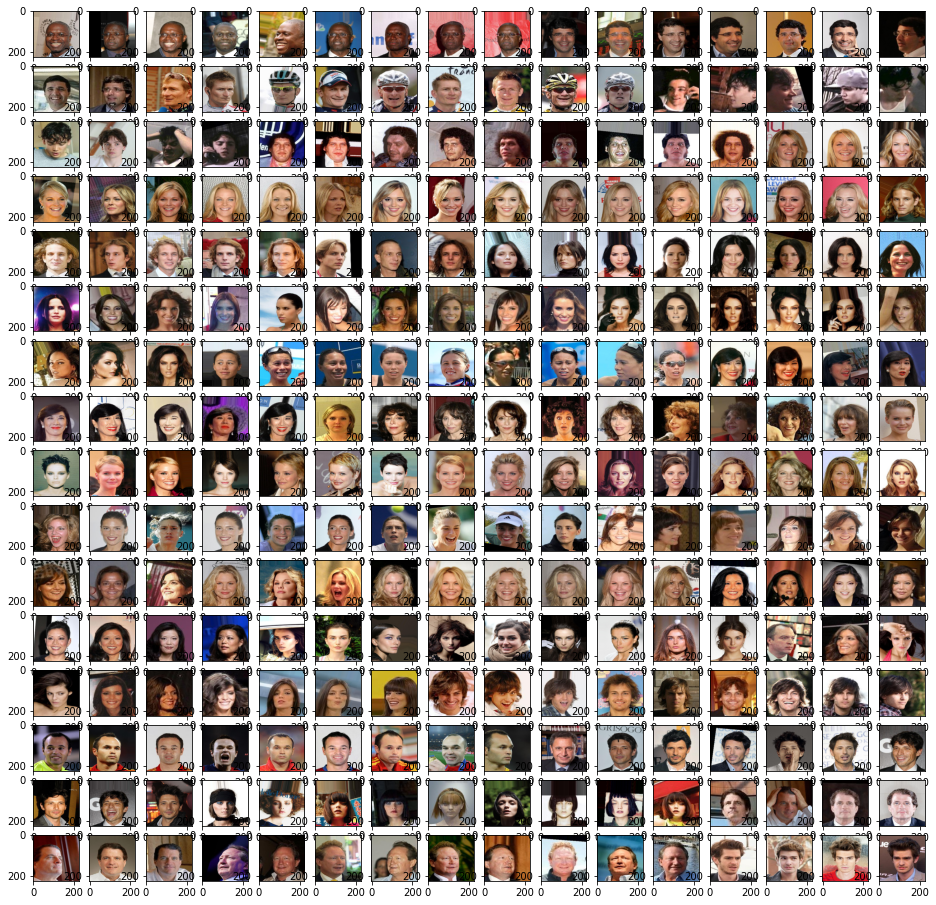

In [37]:
fig, ax = plt.subplots(16, 16, figsize=(16, 16))
for i in tqdm(range(256)):
    ax[i // 16, i % 16].imshow(load_face(gallery_indexes[i]))

Let's choose, say, the 50th identity in the gallery.

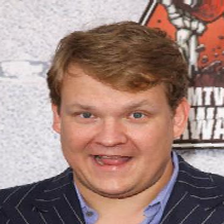

In [39]:
identity = 50

target_face = None
target_index = None
target_id = test_ids[identity]
for i, face in enumerate(celeb_embeddings):
    if celeb_labels[i] == target_id and i not in gallery_indexes:
        target_face = face
        target_index = i
        break

load_face(target_index)

In [40]:
def compose_dataset(gallery, target_face):
    composed = []
    for face in gallery:
        composed.append(np.concatenate((target_face, face)))
    return np.array(composed)
        
composed = compose_dataset(gallery, target_face)

Use the trained model to find the best match in the gallery.

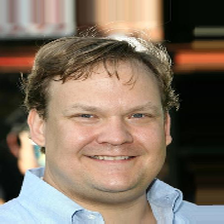

In [41]:
load_face(gallery_indexes[np.argmin(fc_model(composed).numpy().squeeze())])

Save the embeddings 

In [42]:
embeddings_left = model_encoder(slice_layer_1(composed)).numpy()
embeddings_right = model_encoder(slice_layer_2(composed)).numpy()
pairs = np.concatenate((embeddings_left, embeddings_right), axis=1)
np.save('data/CRYPTOFACE_testpairs_gallerymatch.npy', pairs)

## Encrypted domain

In [43]:
%cd ..

/home/han/Desktop/part-ii-project/part-ii-project


In [44]:
import numpy as np
from tqdm import tqdm
from utils.data_loader import load_data
from crypto.schemes import *
from model.lin_algebra import *
from model.creator import Creator
from model.revealer import Revealer
import math
import time
import torch
from keras.layers import ZeroPadding2D
import model.low_lat as low_lat
from utils.logger import msg, OutFlags
from model.model_builder import *

In [45]:
N = 8192 * 1
scheme, decryptor = init_scheme_ckks(N, primes=[32, 25, 25, 25, 25, 25, 32], scale_factor=25)
creator = Creator(scheme)
revealer = Revealer(scheme, decryptor)

model = Model(creator)
model.add(InputLayer(input_shape=(2, 1, 64)))
model.add(SubLayer(size=64))
model.add(DenseLayer(output_length=64))
model.add(ActivationLayer(mode='square'))
model.add(DenseLayer(output_length=1))

weights = np.load('data/CRYPTOFACE_weights.npy', allow_pickle=True)

In [46]:
model.compile(data_mode=0)
model.load_weights(weights, scale=16)
model.summary()

-------Summary of model-------
Name                       Input shape                Output shape               
input0                     (2, 1, 64)                 (2, 1, 64)                 
distance1                  (2, 1, 64)                 (1, 1, 64)                 
dense2                     (1, 1, 64)                 (1, 1, 64)                 
activation_square3         (1, 1, 64)                 (1, 1, 64)                 
dense4                     (1, 1, 64)                 (1, 1, 1)                  


Check what the encrypted model predicts over the test set.

In [47]:
def get_features(n, batch_size):
    test_features = np.load('data/CRYPTOFACE_testpairs.npy')
    test_features = test_features[n * batch_size: min((n + 1) * batch_size, len(test_features))]
    test_features = test_features.reshape((test_features.shape[0], 1, 2, 64))
    test_features = test_features.transpose((0, 1, 3, 2))
    
    ps = np.load('data/CRYPTOFACE_preds.npy', allow_pickle=True)
    ps = ps[n * batch_size: min((n + 1) * batch_size, len(ps))]
    
    return test_features, ps

def to_binary(arr):
    arr_ = []
    for v in arr:
        arr_.append(int(round(v)))
    return arr_

sigmoid = lambda x : 1 / (1 + math.exp(-x))

def run_model(n):
    test_features, ps = get_features(n, batch_size=N//2)
    
    temp = creator.encrypt_simd(mat=test_features)
    
    outputs = model.predict(input_data=creator.encrypt_simd(mat=test_features))
    
    outputs = revealer.reveal_outputs(outputs, N//2, 1)
        
    print(accuracy(to_binary([sigmoid(o) for o in outputs]), to_binary(ps)))
    
run_model(0)


Applying layer::input0
Time elapsed::9e-05
Applying layer::distance1
Time elapsed::0.74777
Applying layer::dense2



Time elapsed::18.80803
Applying layer::activation_square3
Time elapsed::0.42848
Applying layer::dense4



Time elapsed::0.23811
Total inference time::20.22251
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
distance1           128       -         64        -         64        -         0.748     
dense2              8065      1         3968      4096      -         -         18.808    
activation_square3  64        -         -         -         64        -         0.428     
dense4              127       1         62        64        -         -         0.238     
Total               8384      2         4094      4160      128       -         20.222    
0.993896484375


Apply to the gallery matching problem

In [76]:
pairs = np.load('data/CRYPTOFACE_testpairs_gallerymatch.npy')
pairs = pairs.reshape((pairs.shape[0], 1, 2, 64))
pairs = pairs.transpose((0, 1, 3, 2))
pairs.shape

(3296, 1, 64, 2)

In [77]:
t1 = time.process_time()
encrypted = creator.encrypt_simd(mat=pairs)
print('Encryption time', str(time.process_time() - t1), OutFlags.INFO)


Encryption time 1.1437312010000085 


In [88]:
t1 = time.process_time()
outputs = model.predict(input_data=encrypted)
print('Inference time', str(time.process_time() - t1))

t1 = time.process_time()
outputs = revealer.reveal_outputs(outputs, N//2, data_mode=1)
print('Decryption time', str(time.process_time() - t1))

Applying layer::input0
Time elapsed::0.00031
Applying layer::distance1
Time elapsed::0.57963
Applying layer::dense2



Time elapsed::16.35685
Applying layer::activation_square3
Time elapsed::0.30289
Applying layer::dense4



Time elapsed::0.19246
Total inference time::17.43219
------Summary of operations------
Layer               #HOPS     #AddPC    #AddCC    #MulPC    #MulCC    #Rots     Time      
input0              -         -         -         -         -         -         -         
distance1           128       -         64        -         64        -         0.58      
dense2              8065      1         3968      4096      -         -         16.357    
activation_square3  64        -         -         -         64        -         0.303     
dense4              127       1         62        64        -         -         0.192     
Total               8384      2         4094      4160      128       -         17.432    
Inference time 17.432743930000015
Decryption time 0.0005546689999960108


In [79]:
np.argmin(outputs[:500])

331

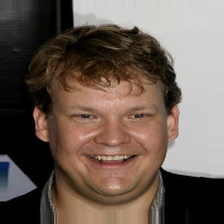

In [86]:
load_face(gallery_indexes[331])